# Post-process of constraining: indicators

Input
- `dataout/unconstrained_run.nc` Results from unconstrained historical runs from `050_unconstrained_run.ipynb`
- `dataout/constraining_ind.nc` Indicators used in MH constraining from `060_constraining.ipynb`
- `dataout/constraining_results.csv` Constrained 600 members from `060_constraining.ipynb`

Output image data
- `image/timeseries_gmst_ohu_cmp2` Time series plot: GSAT and OHC changes
- `image/range_target_indicators` Range plot: target indicators

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import openpyxl
from netCDF4 import Dataset
import matplotlib as mpl

In [2]:
# mce is available in https://github.com/tsutsui1872/mce 
sys.path.append('../mce')

In [3]:
from src.util import RetrieveGitHub
from src.stats import asymmetric_gaussian
from src.plot import MyPlot # depends on mce module

In [4]:
owner = 'IPCC-WG1'
repo = 'Chapter-7'
repo_ch7 = RetrieveGitHub(owner, repo, './datain')

## Reference data

In [5]:
path = 'data_input/observations/AR6 FGD assessment time series - GMST and GSAT.xlsx'
path = repo_ch7.retrieve(path)

[2024-07-22 08:28:47 src.util] INFO:Use local file datain/IPCC-WG1/Chapter-7/data_input/observations/AR6 FGD assessment time series - GMST and GSAT.xlsx retrieved from https://github.com/IPCC-WG1/Chapter-7/raw/main/data_input/observations/AR6%20FGD%20assessment%20time%20series%20-%20GMST%20and%20GSAT.xlsx on 2024-06-20


In [6]:
wb = openpyxl.load_workbook(path, read_only=True, data_only=True)
ws = wb['GMST data sets and changes']
rows = ws.iter_rows(
    min_row=2, # 1-based index
    max_row=2+(2020 - 1850 + 1),
    min_col=12,
    max_col=20,
    values_only=True,
)
columns = next(rows)
df_gmst_obs = (
    pd.DataFrame(list(rows), columns=('Year',) + columns[1:])
    .dropna(axis=1)
    .set_index('Year')
)
wb.close()

In [7]:
path = 'data_input/observations/AR6_OHC_ensemble_FGDprelim.csv'
path = repo_ch7.retrieve(path)

[2024-07-22 08:28:47 src.util] INFO:Use local file datain/IPCC-WG1/Chapter-7/data_input/observations/AR6_OHC_ensemble_FGDprelim.csv retrieved from https://github.com/IPCC-WG1/Chapter-7/raw/main/data_input/observations/AR6_OHC_ensemble_FGDprelim.csv on 2024-06-20


In [8]:
df_ohc_obs = pd.read_csv(path, skiprows=1, index_col=0)

In [9]:
name_central = 'Central Estimate Full-depth'
name_unc = 'Full-depth Uncertainty (1-sigma)'
d_ohu_obs = (df_ohc_obs.loc[2018.5, name_central] - df_ohc_obs.loc[1971.5, name_central])
d_ohu_obs_unc = np.sqrt(
    df_ohc_obs.loc[1971.5, name_unc]**2 + df_ohc_obs.loc[2018.5, name_unc]**2
)

## Read results

### Unconstrained historical runs

In [10]:
# Output of 050_unconstrained_run.ipynb
ncf = Dataset('dataout/unconstrained_run.nc')

In [11]:
list(ncf.variables)

['Member', 'Method', 'Year', 'ohc', 'tg']

In [12]:
method_order = ncf.variables['Method'][:].tolist()
method_order

['ar6', 'ar6_orig', 'mce-2l', 's21']

In [13]:
idx_year = pd.Index(ncf.variables['Year'][:])
idx_year

Int64Index([1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759,
            ...
            2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64', length=270)

In [14]:
nsize = ncf.dimensions['Member'].size
nsize

50000

In [15]:
ncf.variables['tg'].dimensions

('Member', 'Method', 'Year')

In [16]:
mi = pd.MultiIndex.from_product([method_order, idx_year])

In [17]:
df = pd.DataFrame(
    ncf.variables['tg'][:].reshape((nsize, -1)),
    columns=mi,
)

In [18]:
df_base = df.loc[:, (slice(None), slice(1850, 1900))].mean(axis=1, level=0)

In [19]:
df_gsat = pd.concat([
    v.sub(df_base[k], axis=0)
    for k, v in df.groupby(level=0, axis=1)
], axis=1)

In [20]:
df_ohc = pd.DataFrame(
    ncf.variables['ohc'][:].reshape((nsize, -1)),
    columns=mi,
)

In [21]:
ncf.close()

In [22]:
ohu_rate = 0.90 # Use an assumed factor of 0.90

df_ohu_1971_2018 = (
    df_ohc.loc[:, (slice(None), 2018)].droplevel(level=1, axis=1)
    .sub(df_ohc.loc[:, (slice(None), 1971)].droplevel(level=1, axis=1))
    .mul(ohu_rate)
)

In [23]:
# Normalize the heat content values by
# subtracting 2018 values,
# multiplying the ratio of the ocean to the entire system heat content
# and adding an observed 2018 value
df_ohc_norm = (
    pd.concat([
        v.sub(df_ohc.loc[:, (k, 2018)], axis=0)
        for k, v in df_ohc.groupby(level=0, axis=1)
    ], axis=1).mul(ohu_rate).add(df_ohc_obs.loc[2018.5, name_central])
)

### Constraint indicators

Output of 060_constraining.ipynb

In [24]:
ncf = Dataset('./dataout/constraining_ind.nc')

In [25]:
list(ncf.variables)

['Member', 'Method', 'GSAT_1995_2014', 'GSAT_recent_trend', 'OHU_1971_2018']

In [26]:
method_order = ncf.variables['Method'][:].tolist()
method_order

['ar6', 'ar6_orig', 'mce-2l', 's21']

In [27]:
ncf.dimensions['Member'].size

50000

In [28]:
ncf.variables['GSAT_1995_2014'].dimensions

('Member', 'Method')

In [29]:
df_inds = pd.concat({
    k: pd.DataFrame(ncf.variables[k][:], columns=method_order)
    for k in ncf.variables if k not in ncf.dimensions
}, axis=1)

In [30]:
ncf.close()

### Constrained members

Output of 060_constraining.ipynb

Constrained with the MH sampler, except for the AR6 original case

In [31]:
df_members = pd.read_csv(
    './dataout/constraining_results.csv',
    header=[0, 1], index_col=0,
)
mi = [({'ar6_orig': 'ar6_chapter7'}.get(k, 'mh_sampler'), k) for k in method_order]
df_members = df_members[mi].droplevel(0, axis=1)

In [32]:
df_gsat_constrained = pd.concat({
    method:
    df_gsat[method].loc[df_members[method]].reset_index(drop=True)
    for method in method_order
}, axis=1)

In [33]:
df_ohc_norm_constrained = pd.concat({
    method:
    df_ohc_norm[method].loc[df_members[method]].reset_index(drop=True)
    for method in method_order
}, axis=1)

In [34]:
df_inds_constrained = pd.concat([
    v.loc[df_members[k]].reset_index(drop=True)
    for k, v in df_inds.groupby(level=1, axis=1)
], axis=1).sort_index(axis=1)

## Reference indicators

In [35]:
# Same as those in 060_constraining.ipynb
map_rv = {
    'GSAT_1995_2014': asymmetric_gaussian(0.85, (0.67, 0.98)),
    'GSAT_recent_trend': stats.norm(
        loc=0.85 - 0.36,
        scale=np.sqrt(
            asymmetric_gaussian(0.36, (0.22, 0.45)).var()
            +
            asymmetric_gaussian(0.85, (0.67, 0.98)).var()
        ),
    ),
    'OHU_1971_2018': stats.norm(loc=d_ohu_obs, scale=d_ohu_obs_unc),
}

## Plot settings

In [36]:
plt = MyPlot()

In [37]:
map_method = plt.map_method
map_method

{'ar6_orig': '#0 EBM-ε AR6 orig',
 'ar6': '#1 EBM-ε AR6',
 's21': '#2 EBM-ε S21',
 'mce-2l': '#3 MCE-2l'}

In [38]:
map_color = plt.map_color.copy()
map_color.update({
    k: map_color[map_method[k]] for k in method_order
})
map_color['Observation'] = 'C6'
map_color

{'Constrained CMIP6': 'C7',
 'ECS-TCR mapped emulator': 'C6',
 '#0 EBM-ε AR6 orig': 'C9',
 '#1 EBM-ε AR6': 'C0',
 '#2 EBM-ε S21': 'C2',
 '#3 MCE-2l': 'C1',
 'Reference': 'C3',
 'ar6': 'C0',
 'ar6_orig': 'C9',
 'mce-2l': 'C1',
 's21': 'C2',
 'Observation': 'C6'}

In [39]:
map_probability = plt.map_probability
prob_values = list(map_probability)
map_probability, prob_values

({0.05: 'very_likely__lower',
  0.17: 'likely__lower',
  0.5: 'central',
  0.83: 'likely__upper',
  0.95: 'very_likely__upper'},
 [0.05, 0.17, 0.5, 0.83, 0.95])

In [40]:
# for presentation
method_case_order = ['ar6_orig', 'ar6', 's21', 'mce-2l']

## Time series plot: GSAT and OHC changes

In [41]:
dfqset_gsat = [
    df_gsat.quantile(prob_values),
    df_gsat_constrained.quantile(prob_values),
]
dfqset_ohc_norm = [
    df_ohc_norm.quantile(prob_values),
    df_ohc_norm_constrained.quantile(prob_values),
]

In [42]:
dfqset_gsat[0].loc[:, (slice(None), slice(1850, None))]

ar6                                                              \
          1850      1851      1852      1853      1854      1855      1856   
0.05 -0.093479 -0.069078 -0.047385 -0.040032 -0.047016 -0.047746 -0.040242   
0.17 -0.039776 -0.021874 -0.006789 -0.005243 -0.017423 -0.021554 -0.016611   
0.50 -0.001935  0.010721  0.021678  0.019888  0.005572 -0.000322  0.003470   
0.83  0.021447  0.033585  0.044969  0.043058  0.027483  0.020657  0.024075   
0.95  0.040136  0.052878  0.065072  0.063472  0.047376  0.040017  0.043176   

                                    ...       s21                      \
          1857      1858      1859  ...      2010      2011      2012   
0.05 -0.043407 -0.045850 -0.033341  ...  0.553891  0.582558  0.610539   
0.17 -0.022516 -0.026698 -0.015762  ...  0.737641  0.766482  0.795151   
0.50 -0.003353 -0.008938  0.000557  ...  1.048006  1.080218  1.112584   
0.83  0.016565  0.009910  0.018546  ...  1.501515  1.541947  1.582395   
0.95  0.035240  0.027723  0.036060  ...  1.942801  1.991004  2.040385   

                                                                            
          2013      2014      2015      2016      2017      2018      2019  
0.05  0.645185  0.681693  0.713514  0.746447  0.778595  0.808206  0.834550  
0.17  0.830107  0.866642  0.899117  0.930481  0.962435  0.992274  1.020625  
0.50  1.152364  1.193278  1.230292  1.266660  1.303180  1.338196  1.371750  
0.83  1.631095  1.681944  1.727917  1.773033  1.818338  1.865156  1.908392  
0.95  2.094768  2.156152  2.211767  2.264466  2.315673  2.369534  2.423587  

[5 rows x 680 columns]

In [43]:
dfqset_gsat[1].loc[:, (slice(None), slice(1850, None))]

ar6                                                              \
          1850      1851      1852      1853      1854      1855      1856   
0.05 -0.020609 -0.009786 -0.002325 -0.007010 -0.024274 -0.027489 -0.020572   
0.17 -0.012901 -0.002499  0.004903  0.001148 -0.014409 -0.019034 -0.014898   
0.50 -0.001830  0.009045  0.016944  0.012839 -0.001573 -0.007862 -0.004607   
0.83  0.007693  0.019204  0.030786  0.027336  0.011403  0.004303  0.007232   
0.95  0.017572  0.028690  0.039082  0.037379  0.021221  0.013276  0.016619   

                                    ...       s21                      \
          1857      1858      1859  ...      2010      2011      2012   
0.05 -0.027740 -0.030309 -0.018156  ...  0.852333  0.872565  0.895197   
0.17 -0.021443 -0.025299 -0.014339  ...  0.918143  0.940174  0.962504   
0.50 -0.011794 -0.017002 -0.007671  ...  0.999294  1.024387  1.050601   
0.83  0.000101 -0.006109  0.002835  ...  1.108734  1.139061  1.170000   
0.95  0.008941  0.001534  0.010211  ...  1.185745  1.215294  1.252215   

                                                                            
          2013      2014      2015      2016      2017      2018      2019  
0.05  0.922264  0.948263  0.967240  0.986657  1.006070  1.025543  1.050863  
0.17  0.991061  1.021318  1.045478  1.069533  1.092335  1.113139  1.133649  
0.50  1.081809  1.116299  1.144424  1.170720  1.196583  1.221372  1.246582  
0.83  1.206165  1.244280  1.276476  1.308586  1.340436  1.371710  1.403059  
0.95  1.287331  1.328913  1.365816  1.405277  1.450115  1.488031  1.522270  

[5 rows x 680 columns]

In [44]:
dfqset_ohc_norm[0].loc[:, (slice(None), slice(1971, None))]

ar6                                                              \
            1971        1972        1973        1974        1975        1976   
0.05 -190.351723 -184.771213 -177.650302 -170.200907 -165.311315 -160.107696   
0.17  -90.628145  -86.847811  -81.231712  -75.631765  -72.318160  -68.720784   
0.50   24.355422   26.383932   30.131071   33.916869   35.426011   37.322211   
0.83  121.758986  122.055246  123.859799  125.956935  125.786964  125.900258   
0.95  183.121426  182.251463  183.032802  183.764013  182.550447  181.695172   

                                                      ...         s21  \
            1977        1978        1979        1980  ...        2010   
0.05 -152.399932 -142.656798 -132.155258 -121.699707  ...  237.983644   
0.17  -62.238198  -54.248864  -45.562785  -36.887935  ...  260.191839   
0.50   41.850691   47.742762   54.231954   60.492253  ...  286.930480   
0.83  128.699903  132.816422  137.390155  141.887409  ...  308.366699   
0.95  183.386678  186.321399  189.838078  193.228180  ...  322.760157   

                                                                              \
            2011        2012        2013        2014        2015        2016   
0.05  255.873611  274.289852  293.706079  313.830204  333.861822  354.003886   
0.17  275.457916  291.077736  307.717738  325.105400  342.293139  359.663922   
0.50  299.036384  311.401319  324.823102  338.826790  352.640404  366.615697   
0.83  317.995212  327.804003  338.619293  349.967787  361.028507  372.263071   
0.95  330.746937  338.925820  348.046947  357.641942  366.868759  376.206994   

                                          
            2017        2018        2019  
0.05  374.541822  395.279454  404.776551  
0.17  377.389076  395.279454  406.803465  
0.50  380.893909  395.279454  409.690617  
0.83  383.741846  395.279454  413.253832  
0.95  385.735376  395.279454  416.155577  

[5 rows x 196 columns]

In [45]:
dfqset_ohc_norm[1].loc[:, (slice(None), slice(1971, None))]

ar6                                                             \
            1971        1972        1973        1974        1975       1976   
0.05 -124.762764 -119.753034 -112.900566 -106.121670 -101.942611 -98.121214   
0.17  -79.437797  -76.125767  -69.919525  -63.809876  -60.206563 -55.465342   
0.50  -17.955300  -13.933465   -8.801400   -3.568597   -0.233433   3.520871   
0.83   37.235282   39.814609   44.694203   49.201696   51.473645  54.335100   
0.95   78.294430   80.733739   84.669638   88.453978   90.247487  92.599733   

                                                     ...         s21  \
           1977        1978        1979        1980  ...        2010   
0.05 -91.132007  -82.991627  -73.049513  -63.769498  ...  256.945434   
0.17 -48.509359  -40.052298  -31.085173  -23.351260  ...  269.324055   
0.50   9.970351   17.491742   25.648064   33.098102  ...  286.344931   
0.83  60.028981   67.480619   75.140609   82.425005  ...  302.821092   
0.95  98.093288  105.239884  112.847495  118.726612  ...  313.801762   

                                                                              \
            2011        2012        2013        2014        2015        2016   
0.05  272.551413  288.437120  305.622629  323.211720  340.844504  358.659471   
0.17  283.478487  298.051671  313.827869  330.267261  346.233303  362.342489   
0.50  298.530868  311.551967  325.101012  339.399177  353.282470  367.069382   
0.83  313.535406  324.451892  336.299792  348.557497  360.065317  371.677725   
0.95  323.224149  332.925126  343.451919  354.330548  364.434336  374.468177   

                                          
            2017        2018        2019  
0.05  376.868482  395.279454  405.675574  
0.17  378.748505  395.279454  407.199936  
0.50  381.099072  395.279454  409.547732  
0.83  383.427502  395.279454  411.849524  
0.95  384.847698  395.279454  413.745395  

[5 rows x 196 columns]

[2024-07-22 08:29:02 mce] INFO:saved to ./image/timeseries_gmst_ohu_cmp2.png


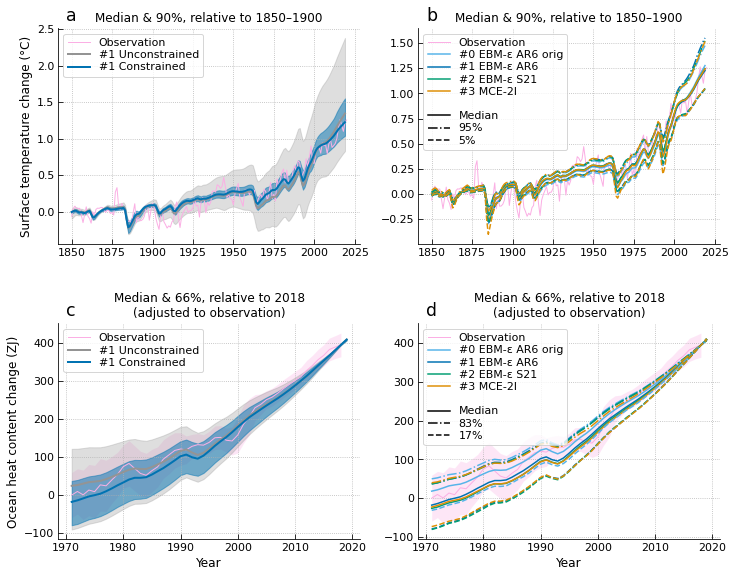

In [46]:
plt.init_regular(4, col=2, kw_space={'hspace': 1.1})

ax = plt(0)

df_gmst_obs['4-set mean'].plot(
    ax=ax, color=map_color['Observation'], label='Observation',
)

method_ref = 'ar6'
kw_legend = {
    'loc': 'upper left',
    'labelspacing': 0.2,
}

for dfq, color, alpha, label in zip(
    dfqset_gsat,
    ['C7', map_color[method_ref]],
    [0.3, 0.5],
    ['Unconstrained', 'Constrained'],
):
    df = dfq[method_ref].loc[:, 1850:]
    ax.fill_between(
        df.columns.values, df.loc[0.95].values, df.loc[0.05].values,
        color=color, alpha=alpha,
    )
    df.loc[0.5].plot(ax=ax, color=color, lw=2., label=label)

handles, labels = ax.get_legend_handles_labels()
labels = labels[:1] + [
    '{} {}'.format(map_method[method_ref][:2], l1)
    for l1 in labels[1:]
]
ax.legend(handles, labels, **kw_legend)
handles_a = handles
labels_a = labels

ax.set_title('Median & 90%, relative to 1850–1900')
ax.set_ylabel('Surface temperature change (°C)')
ax.set_xlabel('')
ax.grid()

ax = plt(1)

handles = [
    mpl.lines.Line2D([0], [0], color=map_color['Observation']),
] + [
    mpl.lines.Line2D([0], [0], color=map_color[method], lw=1.5)
    for method in method_case_order
] + [
    mpl.patches.Patch(alpha=0, linewidth=0),
    mpl.lines.Line2D([0], [0], color='k', lw=1.5, ls='-'),
    mpl.lines.Line2D([0], [0], color='k', lw=1.5, ls='-.'),
    mpl.lines.Line2D([0], [0], color='k', lw=1.5, ls='--'),
]
labels = ['Observation'] + [
    map_method[method] for method in method_case_order
] + [
    '', 'Median', '95%', '5%',
]

df_gmst_obs['4-set mean'].plot(
    ax=ax, color=map_color['Observation'], label='Observation',
)
for prob, ls in zip([0.5, 0.95, 0.05], ['-', '-.', '--']):
    dfqset_gsat[1].loc[prob].unstack(0).loc[1850:, method_case_order].plot(
        ax=ax, legend=False, color=map_color, ls=ls, lw=1.5,
    )

ax.legend(handles, labels, **kw_legend)
handles_b = handles
labels_b = labels
ax.set_title('Median & 90%, relative to 1850–1900')
ax.set_xlabel('')
ax.grid()

ax = plt(2)

ax.fill_between(
    df_ohc_obs[name_central].index.values - 0.5,
    df_ohc_obs[name_central].values - df_ohc_obs[name_unc].values,
    df_ohc_obs[name_central].values + df_ohc_obs[name_unc].values,
    color=map_color['Observation'], lw=0., alpha=0.3,
)
ax.plot(
    df_ohc_obs[name_central].index.values - 0.5,
    df_ohc_obs[name_central].values,
    color=map_color['Observation'], label='Observation',
)
for dfq, color, alpha, label in zip(
    dfqset_ohc_norm,
    ['C7', map_color[method_ref]],
    [0.3, 0.5],
    ['Unconstrained', 'Constrained'],
):
    df = dfq[method_ref].loc[:, 1971:]
    ax.fill_between(
        df.columns.values, df.loc[0.83].values, df.loc[0.17].values,
        color=color, alpha=alpha,
    )
    df.loc[0.5].plot(ax=ax, color=color, lw=2., label=label)

ax.legend(handles_a, labels_a, **kw_legend)
ax.set_title('Median & 66%, relative to 2018\n(adjusted to observation)')
ax.set_xlabel('Year')
ax.set_ylabel('Ocean heat content change (ZJ)')
ax.grid()

ax = plt(3)

ax.fill_between(
    df_ohc_obs[name_central].index.values - 0.5,
    df_ohc_obs[name_central].values - df_ohc_obs[name_unc].values,
    df_ohc_obs[name_central].values + df_ohc_obs[name_unc].values,
    color=map_color['Observation'], lw=0., alpha=0.3,
)
ax.plot(
    df_ohc_obs[name_central].index.values - 0.5,
    df_ohc_obs[name_central].values,
    color=map_color['Observation'], label='Observation',
)
for prob, ls in zip([0.5, 0.83, 0.17], ['-', '-.', '--']):
    dfqset_ohc_norm[1].loc[prob].unstack(0).loc[1971:, method_case_order].plot(
        ax=ax, legend=False, color=map_color, ls=ls, lw=1.5,
    )

labels_b[-2:] = ['83%', '17%']
ax.legend(handles_b, labels_b, **kw_legend)
ax.set_title('Median & 66%, relative to 2018\n(adjusted to observation)')
ax.set_xlabel('Year')
ax.grid()

plt.panel_label()
plt.savefig('./image/timeseries_gmst_ohu_cmp2.png')

## Range plot: target indicators

In [47]:
dfq = pd.concat([
    pd.concat({
        'Unconstrained':
        df_inds.quantile(prob_values),
        'Constrained':
        df_inds_constrained.quantile(prob_values),
    }, axis=1)
    .reorder_levels([1, 0, 2], axis=1)
    .rename(map_method, level=2, axis=1),
    pd.DataFrame({
        (k, 'Constrained', 'Reference'):
        v.ppf(prob_values) if hasattr(v, 'ppf')
        else np.quantile(v, prob_values)
        for k, v in map_rv.items()
    }, index=prob_values),
], axis=1).sort_index(axis=1).rename(map_probability).sort_index()
dfq

GSAT_1995_2014                                      \
                         Constrained                                       
                   #0 EBM-ε AR6 orig #1 EBM-ε AR6 #2 EBM-ε S21 #3 MCE-2l   
central                     0.874992     0.872078     0.878957  0.878357   
likely__lower               0.777257     0.795864     0.799772  0.789813   
likely__upper               0.962534     0.957903     0.957711  0.948694   
very_likely__lower          0.732129     0.745053     0.753373  0.739950   
very_likely__upper          1.001088     1.041289     1.015134  1.004356   

                                                                          \
                                 Unconstrained                             
                   Reference #0 EBM-ε AR6 orig #1 EBM-ε AR6 #2 EBM-ε S21   
central             0.850668          0.819928     0.868437     0.887229   
likely__lower       0.747173          0.570685     0.595811     0.604589   
likely__upper       0.925369          1.158350     1.253911     1.284234   
very_likely__lower  0.672764          0.421128     0.423112     0.425175   
very_likely__upper  0.982209          1.512282     1.642517     1.676319   

                             GSAT_recent_trend  ...                \
                                   Constrained  ... Unconstrained   
                   #3 MCE-2l #0 EBM-ε AR6 orig  ...     #3 MCE-2l   
central             0.908051          0.572080  ...      0.676432   
likely__lower       0.599581          0.496299  ...      0.544829   
likely__upper       1.304256          0.655112  ...      0.852897   
very_likely__lower  0.392289          0.455778  ...      0.472493   
very_likely__upper  1.679737          0.691874  ...      1.001792   

                       OHU_1971_2018                                        \
                         Constrained                                         
                   #0 EBM-ε AR6 orig #1 EBM-ε AR6 #2 EBM-ε S21   #3 MCE-2l   
central                   377.177857   413.234755   421.597836  418.199690   
likely__lower             345.368146   358.044173   358.743455  355.545006   
likely__upper             426.625961   474.717251   476.196464  468.727749   
very_likely__lower        332.036697   316.985025   317.291062  312.354964   
very_likely__upper        449.945981   520.042219   513.761333  504.238991   

                                                                            \
                                   Unconstrained                             
                     Reference #0 EBM-ε AR6 orig #1 EBM-ε AR6 #2 EBM-ε S21   
central             395.279454        341.376573   370.924032   378.017134   
likely__lower       331.281565        246.678806   273.520468   278.041383   
likely__upper       459.277344        472.332817   485.907600   499.906083   
very_likely__lower  284.955629        195.838375   212.158028   212.426959   
very_likely__upper  505.603279        604.300762   585.631178   603.432848   

                                
                                
                     #3 MCE-2l  
central             378.089698  
likely__lower       267.675537  
likely__upper       504.299998  
very_likely__lower  193.814058  
very_likely__upper  608.079469  

[5 rows x 27 columns]

[2024-07-22 08:29:03 mce] INFO:saved to ./image/range_target_indicators.png


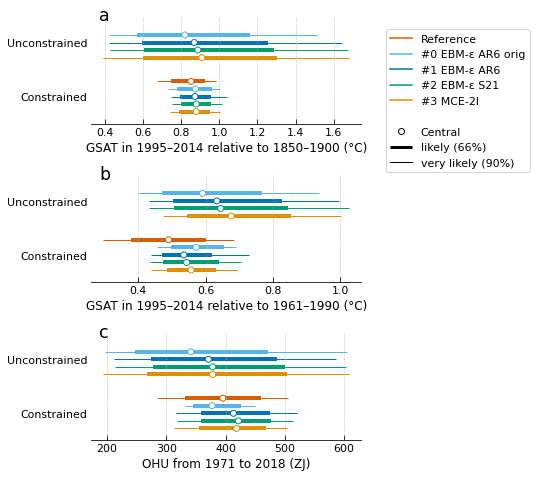

In [48]:
map_name_unit = {
    'GSAT_1995_2014': ('GSAT in 1995–2014 relative to 1850–1900', '°C'),
    'GSAT_recent_trend': ('GSAT in 1995–2014 relative to 1961–1990', '°C'),
    'OHU_1971_2018': ('OHU from 1971 to 2018', 'ZJ'),
}

plt.plot_quantile_range(
    dfq,
    group_order=['Unconstrained', 'Constrained'],
    member_order=['Reference'] + [map_method[k] for k in method_case_order],
    map_color=map_color,
    map_name_unit=map_name_unit,
)

plt.panel_label(va='center', xytext=(8, 0))
plt.savefig('./image/range_target_indicators.png')